### `Seurat` 专用于单细胞RNA-seq数据的QC、分析和探索研究。
- Seurat 使用各种计算技术（包括降维、聚类和可视化）来分析 scRNA-seq 数据。
- 它采用主成分分析 (PCA) 和 t 分布随机邻域嵌入 (t-SNE) 算法将高维基因表达数据减少到低维空间。
- 通过这样做，它揭示了单个细胞之间的潜在模式和关系，使研究人员能够识别不同的细胞类型、状态或种群
### 数据下载和软件安装
- [X] 2700个外周血单个核细胞（PMBC）的转录组数据，测序平台是Illumina NextSeq 500测序仪

- [X] 数据下载 https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
   - [ ] 这个应该是`Cellranger`处理的结果数据，因为测序原始数据为`fastq`格式的
```
cellranger count \
--id= sample1 \
--transcriptome= "refdata-cellranger-GRCh38-3.00/" \
--fastqs= "./sample1/" \
--r2-length = 98

# --id 为输出文件名
# 输出结果每个样本包含3个文件：barcode, features(genes), matrix
```

- [X] 安装Seurat软件
```
install.packages('Seurat')
```

In [ ]:
library(dplyr)
library(Seurat)
library(patchwork)

### 00 raw data改名、分组，然后合并

In [ ]:
# 对scRNA目录下的多样本raw data进行改名，分组文件夹
library(tidyverse)
f_list = list.files('./scRNA/','SY$')

samples = str_split(f_list, '_', simplify = T)[,1]
lapply(unique(samples), function(x){
    y = f_list[grepl(x, f_list)]
    folder = paste0("scRNA/", str_split(y[1], '_', simplify=T)[,1])
    dir.create(folder, recursive=T)
    
    file.rename(paste0("scRNA/", y[1]), file.path(folder, "barcodes.tsv.gz"))
    file.rename(paste0("scRNA/", y[2]), file.path(folder, "features.tsv.gz"))
    file.rename(paste0("scRNA/", y[3]), file.path(folder, "matrix.mtx.gz")) 
})

# 多样本合并
# 方法1  -- 直接全部读入，创建对象，就这个吧，方便
counts = Read10X(data.dir = dir)
scRNA1 = CreateSeuratObject(counts, min.cells=1, verbose=F)
dim(scRNA1)
table(scRNA1@meta.data$orig.ident)

# 方法2 -- 对每个样本创建对象，再将所有对象合并
scRNAlist = list()
for(i in 1:length(dir)){
    print(i)
    counts = Read10X(data.dir = dir[i])
    scRNAlist[[i]] = CreateSeuratObject(counts, min.cells=1)
}
scRNA2 = merge(scRNAlist[[1]], y=c(scRNAlist[[2]], scRNAlist[[3]],scRNAlist[[4]], 
                                  scRNAlist[[5]], scRNAlist[[6]], scRNAlist[[7]],
                                  scRNAlist[[8]], scRNAlist[[9]], scRNAlist[[10]]))
dim(scRNA2)
table(scRNA2@meta.data$orig,ident)

### 1 创建Seurat对象

In [90]:
# 加载数据，Read10X函数从指定目录中读取数据集，会返回一个UMI计数矩阵
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")

# 初始化数据, CreateSeuratObject函数创建一个Seurat对象
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", 
                          min.cells = 3, min.features = 200)
pbmc
head(pbmc@meta.data)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACAACCAC-1,pbmc3k,2419,779
AAACATTGAGCTAC-1,pbmc3k,4903,1352
AAACATTGATCAGC-1,pbmc3k,3147,1129
AAACCGTGCTTCCG-1,pbmc3k,2639,960
AAACCGTGTATGCG-1,pbmc3k,980,521
AAACGCACTGGTAC-1,pbmc3k,2163,781


## 数据预处理
- 预处理一般可分为5个处理阶段
  - 1、原始数据
  - 2、标准化后的数据
  - 3、矫正后的数据
  - 4、特征选择后的数据
  - 5、降维后的数据
### 2 过滤
- 根据nFeature_RNA和MT基因占比过滤一些细胞

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


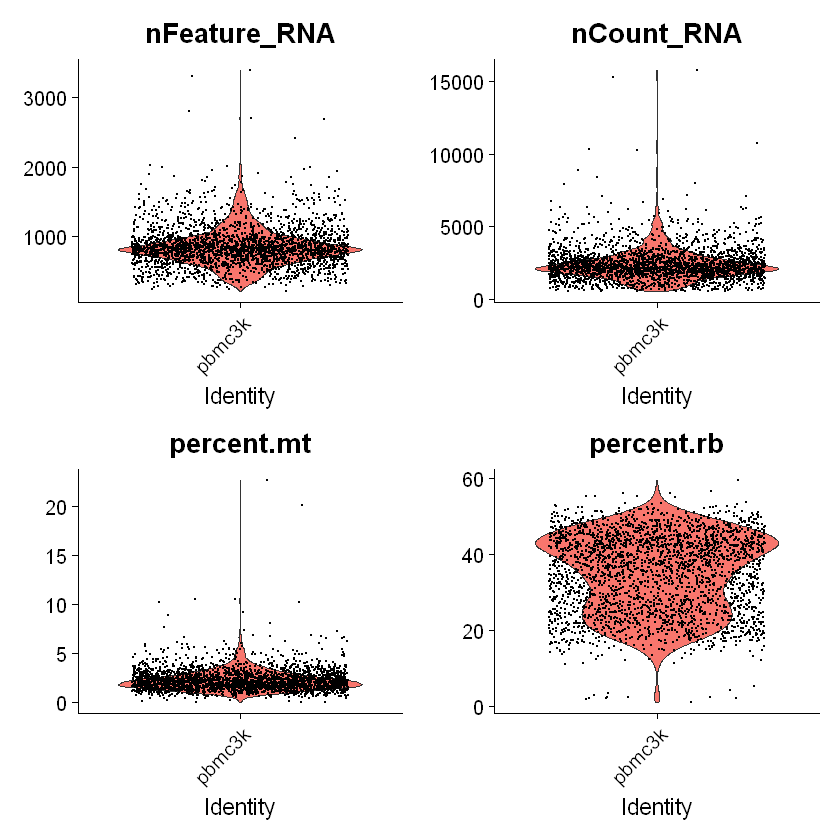

In [95]:
# 计算每个细胞中线粒体（MT）基因的百分比
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
# 计算每个细胞中核糖体（以 RPS 或 RPL 开头）基因的百分比
pbmc[["percent.rb"]] <- PercentageFeatureSet(pbmc, pattern = "^RP[SL]")
head(pbmc@meta.data)

# 小提琴图展示每个细胞的RNA特征数
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), 
        ncol = 2)

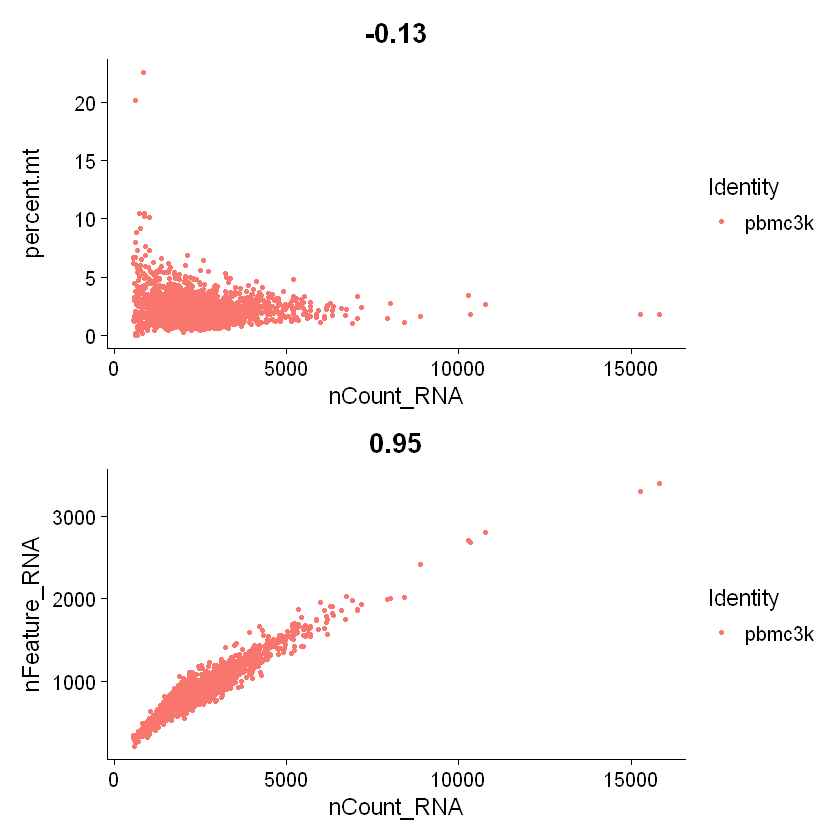

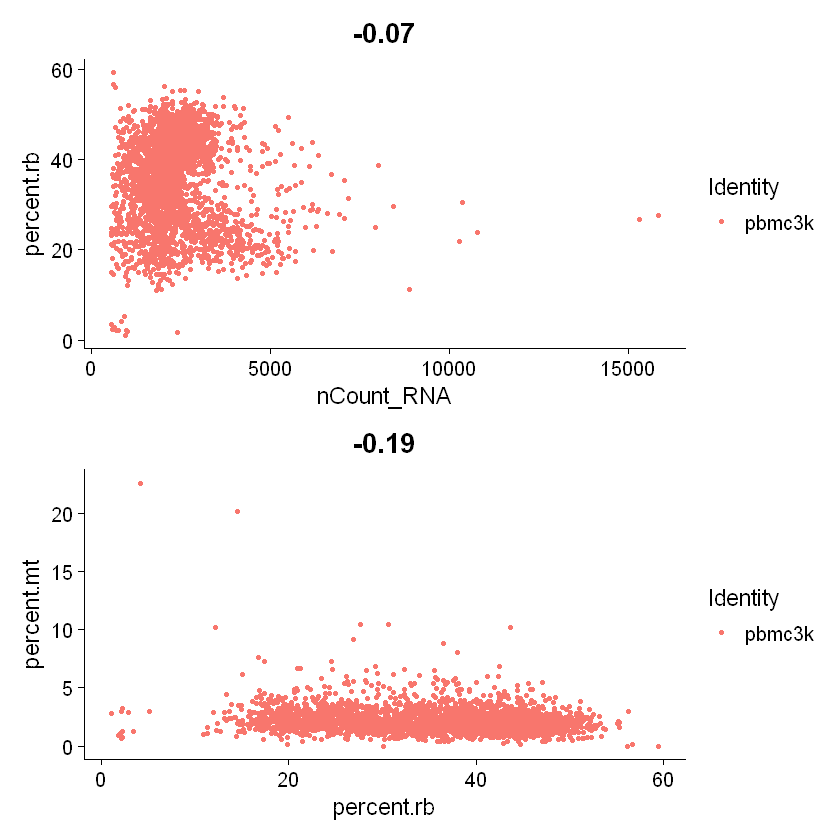

In [99]:
# 根据特征绘制散点图,图上方为pearson相关系数
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.rb")
plot4 <- FeatureScatter(pbmc, feature1 = "percent.rb", feature2 = "percent.mt")
plot1 / plot2
plot3 / plot4

In [100]:
# 根据上述小提琴图和散点图的分布情况，
# 选择nFeature_RNA大于200并且小于2500以及MT基因占比小于5的细胞
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

pbmc
head(pbmc@meta.data)

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


### 3 特征选择
- 计算数据集中表现出细胞间高变异的特征（在某些细胞中高表达，而在其他细胞中低表达）
- 使用`FindVariableFeatures`函数选择在单个细胞之间具有高度变异性的特征（基因），并选择了前2000个作为高变异性的特征（200-2400，特征数量对结果影响不大）
- 使用`VariableFeaturePlot`函数绘制变异特征的图形，并用`LabelPoints`函数标记top10的特征
- 特征选择后，可以通过专用的降维算法进一步对单细胞表达矩阵进行降维。这些算法将表达式矩阵映射到低维空间中，同时以尽可能少的维数捕获数据中所有的信息。

### 4 数据归一化和线性变换
- 数据归一化
  - 从数据集中过滤不需要的细胞后，对数据进行归一化处理
  - 默认采用全局尺度归一化方法`LogNormalize`，通过总表达式对每个细胞的特征表达式测量值进行归一化，将其乘比例因子（默认为10,000），并对结果进行对数转换
- 线性变换
  - 之后，对数据进行线性变换，作为`PCA`等降维处理之前的标准预处理步骤
  - `ScaleData`函数对每个基因的表达值进行平移，使所有细胞的平均表达值为0，并使所有细胞的表达值的方差为1，这一步骤使得在后续的分析中各个基因的权重相等，避免高表达基因对结果的主导影响

Normalizing layer: counts



,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


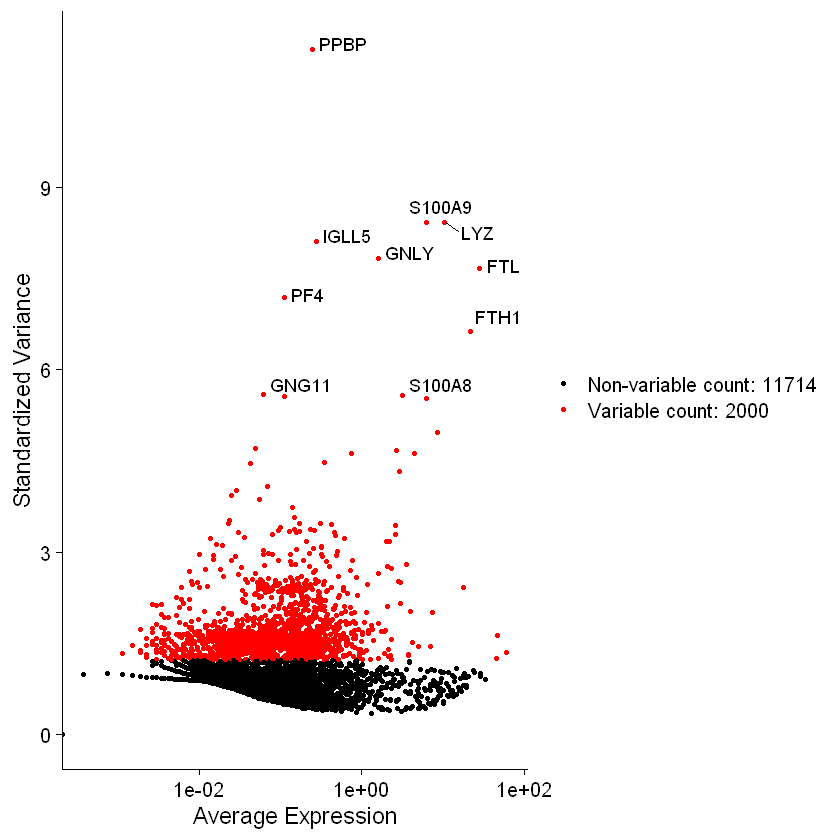

In [101]:
# 数据归一化
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
head(pbmc@meta.data)

# Vst（方差稳定化变换）方法确定具有高度变异性的特征
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000, verbose=FALSE)
head(pbmc@meta.data)

# 确定10个变异最大的基因
top10 <- head(VariableFeatures(pbmc), 10)

# 绘制带标签和不带标签的变量特征图
plot1 <- VariableFeaturePlot(pbmc) 
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, verbose=FALSE) 
plot2

# 线性变换（标准化）
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes, verbose=FALSE)
head(pbmc@meta.data)

### 5 线性降维
- 减轻下游分析工具的计算负担、减少数据中的噪声并方便数据可视化，可以使用多种方法来对数据集进行降维
- 降维有两个主要目标：可视化和信息汇总（summarization）。可视化是尝试在二维或三维空间最优地展示数据集
  - 降维后的维度值就是数据在新的空间进行可视化如绘制散点图时的坐标值。信息汇总没有规定输出的维数；但更高的维数对表示原有数据的差异越来越不重要（PCA中各个主成分对于原始数据差异的解释依次降低）
  - 汇总技术可通过计算数据的固有维数来将数据降维到基本组成（主）成分，从而有助于下游分析。
- 默认情况下，`RunPCA`只对先前确定的变量特征进行降维

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


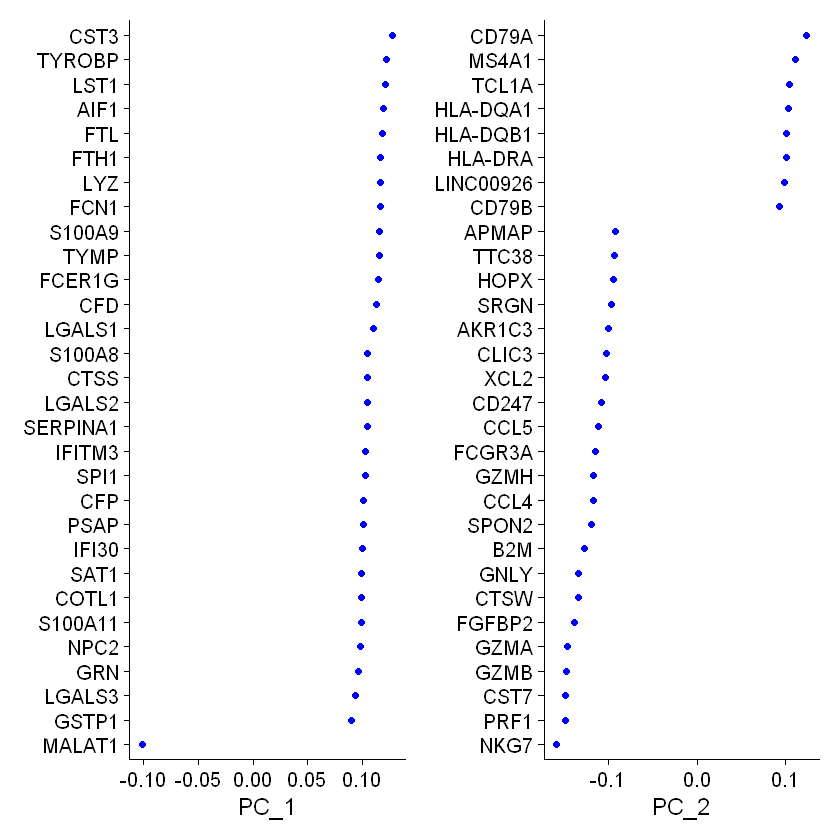

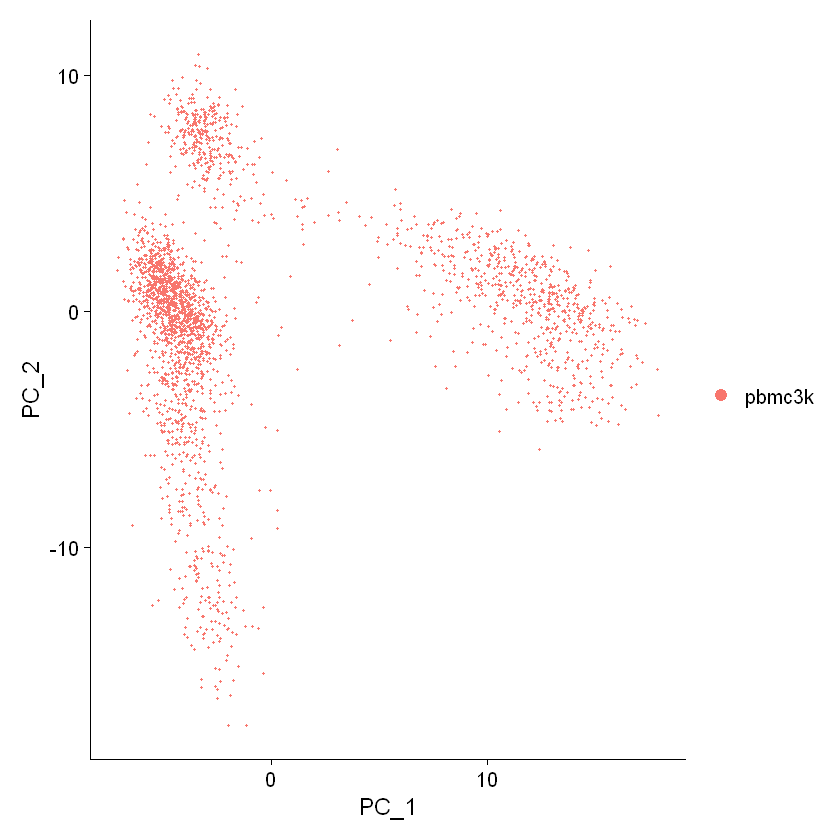

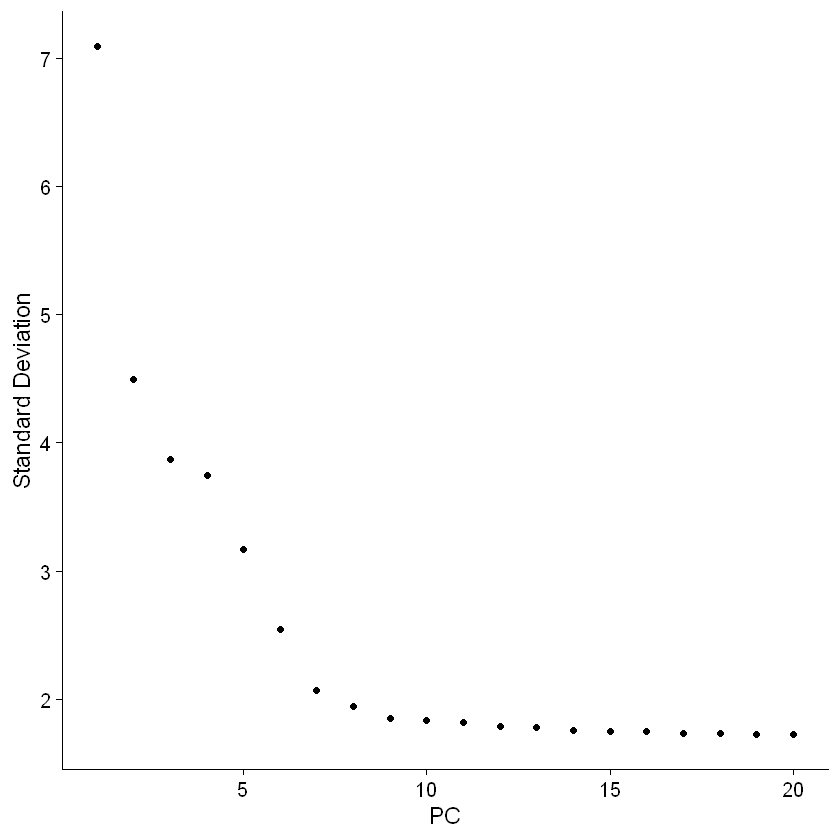

In [102]:
# PCA降维
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc), verbose=FALSE)
head(pbmc@meta.data)

# 可视化
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")
DimPlot(pbmc, reduction = "pca")
ElbowPlot(pbmc)

### 6 确定数据集维度
- 单细胞`RNA-Seq`数据中，每个基因的表达受到大量的“技术“噪音影响。为了克服这种噪音，Seurat使用`PCA`对细胞进行聚类，其中每个主成分实质上表示一组相关特征的综合信息。
- 选择多少个主成分进行聚类？
  - 1 随机对数据的子集进行置换（默认为1%），重新运行PCA，并构建特征分数的“零分布”，重复此过程，将具有显著富集低p值特征的主成分视为“显著”的，保留这些主成分即可。
    - `JackStrawPlot()`函数用于将每个主成分的p值分布与均匀分布（下图虚线）进行比较。
    - 具有低p值特征富集的主成分将显示出在虚线上方的低p值特征的显著富集（实线曲线）。
    - 在这种情况下，第1到12个主成分之后的显著性显著下降，因此对于这个数据集，可以选用的数据数据维度为10，也就是保留10个主成分。
- 用`PCA`选择合适的维度，之后用`UMAP`进行所得维度的降维

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551


Warning message:
"Removed 32525 rows containing missing values (`geom_point()`)."


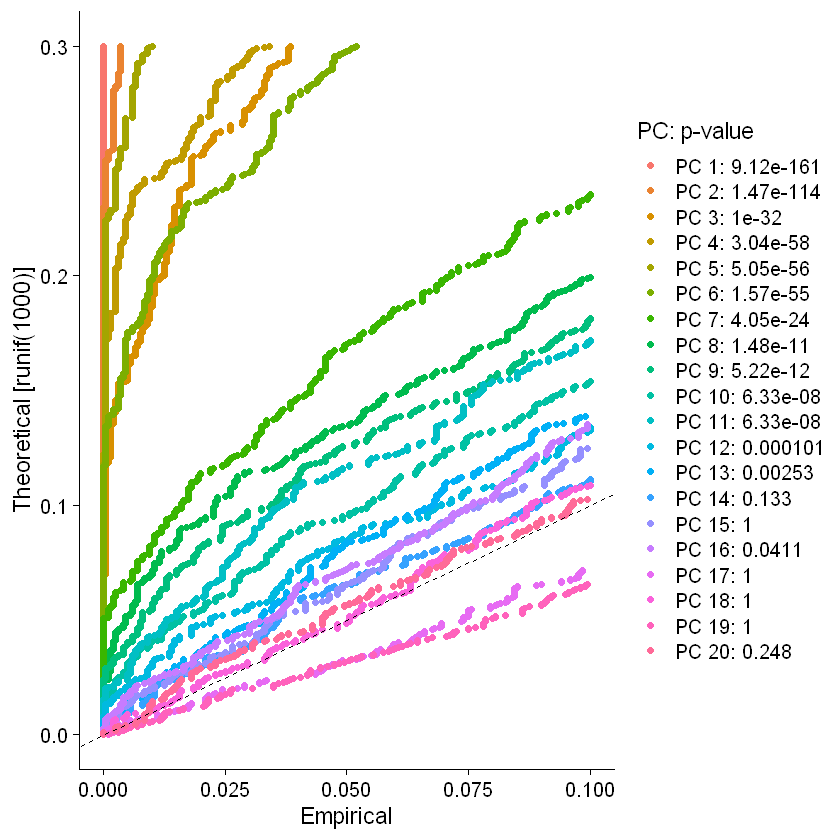

In [80]:
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)
head(pbmc@meta.data)
JackStrawPlot(pbmc, dims = 1:20)

### 7 细胞聚类和UMAP降维
- 细胞聚类
  - 目前多数细胞聚类的算法都是基于图聚类的，具体而言，是将细胞嵌入到一个图结构中，例如K最近邻（KNN）图，其中相似的特征表达模式的细胞之间有边连接，然后试图将该图划分为高度相互连接的“拟团”（quasi-clique）或“群集”（‘communities）。
  - `Seurat`使用的聚类算法也是基于图的，首先在`PCA`空间中基于欧氏距离构建一个KNN图，并根据局部邻域中两个细胞的共享重叠（Jaccard相似度）来调整边的权重。
    - 首先，通过调用`FindNeighbors`函数，将细胞嵌入到一个图结构中。这里使用了数据集的前10个主成分（PCs）作为维度来计算细胞之间的相似性。
    - 通过计算细胞间的欧氏距离，构建了一个K最近邻（KNN）图。该函数还根据局部邻域中细胞的重叠程度（Jaccard相似度），进一步优化了细胞之间的边权重。
    - 接下来，调用`FindClusters`函数对细胞进行聚类分析.该函数通过迭代地将细胞分组，以最大化标准模块度函数来优化聚类结果，模块度函数衡量了细胞在群集中的连接紧密程度。
    - 该函数还有一个`resolution`参数，用于设置聚类的“粒度”，增加参数值将产生更多的聚类。通常情况下，对于包含大约3K个细胞的单细胞数据集，将参数值设置在0.4-1.2之间可以得到良好的结果。对于更大的数据集，通常需要增加分辨率参数值
    - 调用`idents()`函数，可以获取到聚类的结果
 - UMAP 降维
   - Seurat 提供了多种非线性降维技术，例如 tSNE 和 UMAP，以可视化和探索这些数据集。这些算法的目标是学习数据的底层流形，以便将相似的单元格放在低维空间中。
   - 在没有特定生物学问题限制的情况下，我们将UMAP视为探索性数据可视化分析的最佳实践

Computing nearest neighbor graph

Computing SNN



,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574,2,2
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261,3,3
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097,2,2
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161,1,1
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796,6,6
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972,2,2


AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574,2,2
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261,3,3
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097,2,2
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161,1,1
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796,6,6
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972,2,2



  0   1   2   3   4   5   6   7   8 
711 480 472 344 279 162 144  32  14 

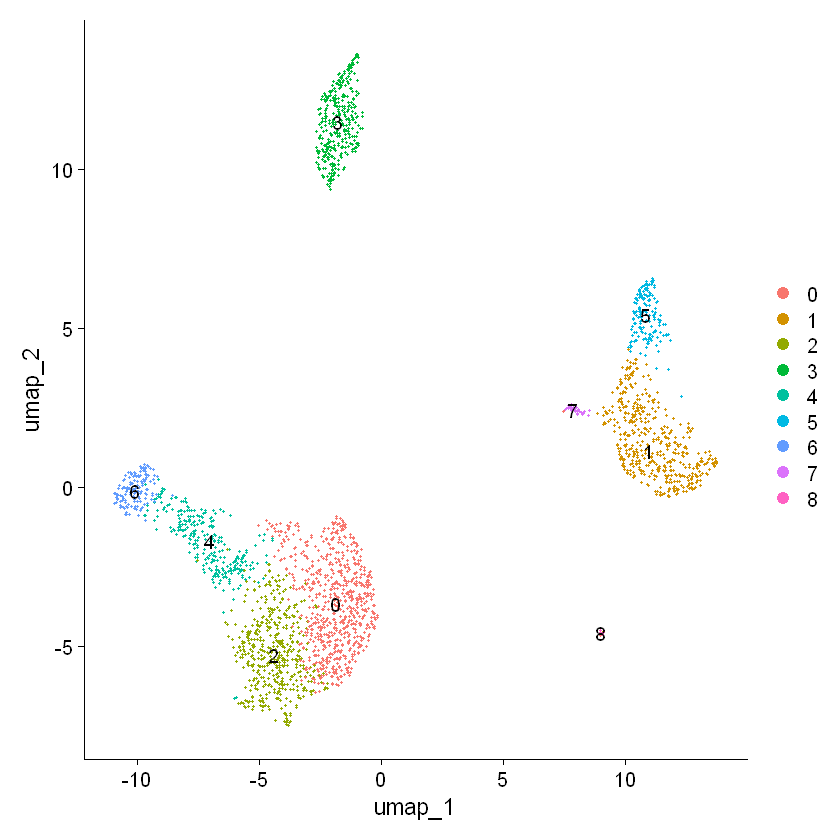

In [103]:
# 细胞聚类
pbmc <- FindNeighbors(pbmc, dims = 1:10)
head(pbmc@meta.data)
pbmc <- FindClusters(pbmc, resolution = 0.5)
head(pbmc@meta.data)
#查看前5个细胞簇的ID
head(Idents(pbmc), 5)

# UMAP降维
pbmc <- RunUMAP(pbmc, reduction = "pca", dims = 1:10, verbose = FALSE)
head(pbmc@meta.data)
table(pbmc@meta.data$seurat_clusters)

DimPlot(pbmc, reduction = "umap", label = TRUE)

In [82]:
pbmc.marker <- FindAllMarkers(object = pbmc, verbose=FALSE)

In [84]:
head(pbmc.marker)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RPS12,1.806317e-144,0.7439459,1.000,0.991,2.477183e-140,0,RPS12
RPS6,7.135900e-142,0.6862148,1.000,0.995,9.786173e-138,0,RPS6
RPS27,5.257820e-140,0.7298479,0.999,0.992,7.210575e-136,0,RPS27
RPL32,4.229582e-136,0.6184804,0.999,0.995,5.800448e-132,0,RPL32
RPS14,1.799019e-130,0.6283021,1.000,0.994,2.467175e-126,0,RPS14
CYBA,1.235790e-129,-1.7444394,0.658,0.917,1.694762e-125,0,CYBA


### 8 获得差异基因
- p_val_adj < 0.05
- avg_log2FC > 1  avg_log2FC < -1

In [89]:
resolution = 0.5
logFC_filter = 1
sig_marker = subset(pbmc.marker,pbmc.marker$p_val_adj < 0.05)
filter_marker_2 = subset(sig_marker,sig_marker$avg_log2FC > logFC_filter)
filter_marker_1 = subset(sig_marker,sig_marker$avg_log2FC < -logFC_filter)
filter_marker = rbind(filter_marker_2,filter_marker_1)
head(filter_marker)
write.table(filter_marker,sep="\t", paste0(resolution,"_CCA_marker.txt"))

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
LDHB,1.740957e-109,1.189519,0.897,0.593,2.387549e-105,0,LDHB
CCR7,1.167632e-83,2.369020,0.435,0.108,1.601290e-79,0,CCR7
CD3D,8.939451e-79,1.086580,0.838,0.403,1.225956e-74,0,CD3D
CD3E,3.053170e-53,1.018288,0.722,0.399,4.187117e-49,0,CD3E
LEF1,3.284150e-49,2.096128,0.333,0.103,4.503883e-45,0,LEF1
NOSIP,6.656031e-49,1.247660,0.623,0.358,9.128080e-45,0,NOSIP
